## Importación de librerías

In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, set_seed
from transformers import RobertaTokenizer, RobertaForSequenceClassification

## Configuración de hiperparámetros

En esta sección configuramos los hiperparámetros y opciones básicas de entrenamiento que controlan cómo se ajustará el modelo durante el fine-tuning.

In [2]:
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
MAX_GRAD_NORM = 1.0

TRAIN_PATH = "/content/data/train.tsv"
VAL_PATH = "/content/data/dev.tsv"
TEST_PATH = "/content/data/test.tsv"

## Lectura de datos

En esta sección se cargan los archivos TSV correspondientes a entrenamiento, validación y prueba.
Se asegura que los datos contengan las columnas esperadas (`id`, `event`, `tweet`, `offensive`, `emotion`) y se eliminan registros nulos en tweet y emotion.
De esta forma, garantizamos que el dataset esté limpio y consistente antes de iniciar el preprocesamiento y el entrenamiento de los modelos.

In [3]:
def read_tsv(path):
    df = pd.read_csv(path, sep="\t", dtype=str)
    expected = {"id", "event", "tweet", "offensive", "emotion"}
    if not expected.issubset(set(df.columns)):
        raise ValueError(f"El archivo {path} debe contener columnas: {expected}. Encontrado: {set(df.columns)}")
    return df

train_df = read_tsv(TRAIN_PATH).dropna(subset=["tweet", "emotion"]).reset_index(drop=True)
test_df = read_tsv(TEST_PATH).dropna(subset=["tweet", "emotion"]).reset_index(drop=True)
val_df = read_tsv(VAL_PATH).dropna(subset=["tweet", "emotion"]).reset_index(drop=True)

print("Registros: train(total)=", len(train_df)," validation=",len(val_df), "  test=", len(test_df))


Registros: train(total)= 5112  validation= 744   test= 1447


## Distribución de clases

Se grafican las distribuciones de la variable emotion en los conjuntos de entrenamiento, validación y prueba.
Esto permite verificar si las clases están balanceadas o si existen desbalances significativos que puedan afectar el rendimiento del modelo.
Además, se muestran los conteos exactos de cada emoción para facilitar la interpretación de los datos antes del entrenamiento.

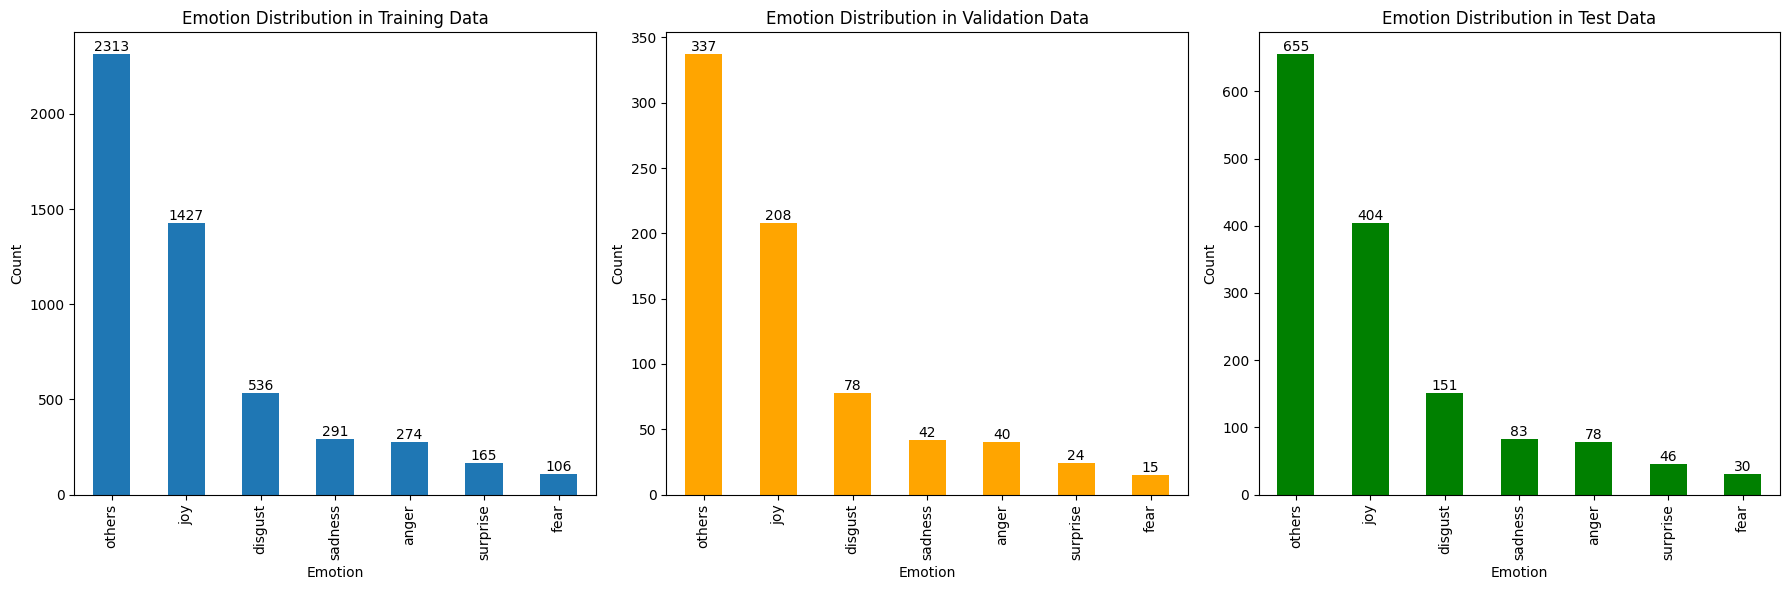

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Train data
train_counts = train_df["emotion"].value_counts()
train_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Emotion Distribution in Training Data')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
for i, count in enumerate(train_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom')


# Validation data
val_counts = val_df["emotion"].value_counts()
val_counts.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Emotion Distribution in Validation Data')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
for i, count in enumerate(val_counts):
    axes[1].text(i, count, str(count), ha='center', va='bottom')


# Test data
test_counts = test_df["emotion"].value_counts()
test_counts.plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title('Emotion Distribution in Test Data')
axes[2].set_xlabel('Emotion')
axes[2].set_ylabel('Count')
for i, count in enumerate(test_counts):
    axes[2].text(i, count, str(count), ha='center', va='bottom')


plt.tight_layout()
plt.show()

De acuerdo a las gráficas, la data está bastante desbalanceada e inclinada hacia la etiqueta "others" y "joy", por lo tanto, se hará un balance de pesos, para un mejor performance.

## Preprocesamiento del texto

En este paso se aplica una limpieza básica de los tweets con el fin de reducir ruido y estandarizar el contenido:

URLs y menciones (@usuario) se eliminan porque no aportan información semántica relevante para la clasificación de emociones.

Se normalizan saltos de línea y espacios en blanco múltiples.

Se genera una nueva columna text con la versión limpia del tweet.

<b>Ejemplo de transformación</b>
| **Texto original**                                     | **Texto limpio**              |
| ------------------------------------------------------ | ----------------------------- |
| "Estoy feliz!! 😃 visita https://t.co/abc123 @amigo" | "Estoy feliz!! 😃 visita"   |
| "Triste por lo que pasó... @noticias"                | "Triste por lo que pasó..." |
| "Gran día!!! #emocionado"                            | "Gran día!!! #emocionado"   |


In [4]:
URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
MENTION_RE = re.compile(r"@\w+")
WS_RE = re.compile(r"\s+")

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = s.replace("\r", " ").replace("\n", " ")
    s = WS_RE.sub(" ", s).strip()
    return s

train_df["text"] = train_df["tweet"].map(clean_text)
val_df["text"] = val_df["tweet"].map(clean_text)
test_df["text"] = test_df["tweet"].map(clean_text)


## Codificación de etiquetas y balance de clases

En esta sección se transforman las emociones de texto a valores numéricos para que los modelos puedan procesarlas:

- Con LabelEncoder, cada emoción se asigna a un entero (label).
- Se construye el diccionario id2label que permite mapear de vuelta los índices a sus clases originales.
- Se calcula el número total de clases (num_labels) detectadas en el dataset.

Además, para mitigar posibles desbalances en la distribución de emociones, se calculan class weights:

- Estos pesos asignan mayor relevancia a las clases minoritarias y menor a las mayoritarias.
- Se convierten a tensores de PyTorch y se utilizan en la función de pérdida durante el entrenamiento.

De esta manera, se busca que el modelo no se sesgue hacia las emociones más frecuentes.

In [5]:
# Etiquetas (LabelEncoder)
le = LabelEncoder()
le.fit(pd.concat([train_df["emotion"], val_df["emotion"], test_df["emotion"]], axis=0))
train_df["label"] = le.transform(train_df["emotion"])
val_df["label"]   = le.transform(val_df["emotion"])
test_df["label"]  = le.transform(test_df["emotion"])

id2label = {str(i): label for i, label in enumerate(le.classes_)}
num_labels = len(le.classes_)
print("Clases detectadas:", list(le.classes_))


# - Calcular class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Clases detectadas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']
Class weights: tensor([2.6653, 1.3625, 6.8895, 0.5118, 0.3157, 2.5096, 4.4260],
       device='cuda:0')


## Tokenización y creación del Dataset

Para que los modelos basados en transformers (como BERT o RoBERTa) puedan procesar el texto, es necesario convertir las oraciones en representaciones numéricas:

- Con la función <b>tokenize_texts</b>:

  - Se convierte cada oración en tokens siguiendo el vocabulario del modelo preentrenado.

  - Se aplica padding para igualar longitudes, truncation para recortar textos demasiado largos y se fija un máximo (MAX_LEN).

  - Se genera también la attention mask, que indica qué tokens son reales y cuáles provienen del padding.

Luego, se define la clase <b>EncodedDataset</b>, que extiende torch.utils.data.Dataset:

- Guarda los tensores input_ids, attention_mask y labels.

- Implementa los metodos __len__ y __getitem__, permitiendo que PyTorch acceda a los datos de manera eficiente durante el entrenamiento.

De esta manera, los tweets quedan listos para ser cargados en <b>DataLoader</b> y procesados en lotes por la red neuronal.

In [6]:
# Tokenizer + Dataset
def tokenize_texts(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True
    )

class EncodedDataset(Dataset):
  def __init__(self, encodings, labels):
      self.input_ids = encodings["input_ids"]
      self.attention_mask = encodings["attention_mask"]
      self.labels = labels
  def __len__(self):
      return len(self.labels)
  def __getitem__(self, idx):
      item = {
          "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
          "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
          "labels": torch.tensor(self.labels[idx], dtype=torch.long)
      }
      return item


## Funciones de entrenamiento y evaluación

En esta sección se definen las funciones encargadas de entrenar y evaluar el modelo:

- train_one_epoch: Ejecuta una pasada completa sobre el conjunto de entrenamiento. Calcula la pérdida con CrossEntropyLoss (ajustada con class_weights para manejar el desbalance). Aplica <b>backpropagation</b>, recorte de gradientes (clip_grad_norm_), y actualiza los parámetros con optimizer y scheduler.

- evaluate: Evalúa el modelo en validación o test sin actualizar parámetros (torch.no_grad()). Calcula las mismas métricas que en entrenamiento.

In [7]:
# Funciones de entrenamiento/evaluación

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    losses = []
    all_preds = []
    all_labels = []
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    acc = accuracy_score(all_labels, all_preds)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)
    return avg_loss, acc, p, r, f1

def evaluate(model, dataloader, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = float(np.mean(losses)) if losses else 0.0
    acc = accuracy_score(all_labels, all_preds) if all_labels else 0.0
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)
    return avg_loss, acc, p, r, f1, np.array(all_preds), np.array(all_labels)


## MODELO 1: BERT

### Construcción del modelo, tokenización y configuración del optimizador

En esta sección se realizan los pasos clave para inicializar el modelo BERT y preparar el flujo de entrenamiento:

- Modelo y tokenizer:

  - Se selecciona bert-base-uncased como modelo preentrenado base.

  - Se carga el tokenizer asociado para transformar texto en tensores (input_ids y attention_mask).

  - Se crean datasets y dataloaders para train/val/test, ya con los textos tokenizados y listos para ser procesados en lotes (batch_size).

- Modelo de clasificación:

  - Se instancia BertForSequenceClassification, añadiendo una capa final adaptada al número de etiquetas (num_labels).

  - Se mueve el modelo a GPU si está disponible.

- Optimizador y regularización:

  - Se usa AdamW, un optimizador recomendado para transformers.

  - Los parámetros se dividen en dos grupos:

    - Con weight decay (regularización L2).

    - Sin weight decay (sesgos y pesos de normalización de capa).

- Scheduler (planificador de tasa de aprendizaje):

  - Se define un esquema de linear warmup and decay:

    - Durante los primeros pasos (warmup_steps) el learning rate aumenta progresivamente.

    - Luego decae linealmente hasta el final del entrenamiento.

  - Esto estabiliza el entrenamiento y evita explosiones de gradientes en las primeras iteraciones.


  <b>(Se usa la misma lógica para los otros dos modelos)</b>

In [ ]:
MODEL_NAME = "bert-base-uncased"
OUTPUT_DIR = "./bert_manual_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
# Tokenizer + Dataset
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_enc = tokenize_texts(train_df["text"].tolist())
val_enc   = tokenize_texts(val_df["text"].tolist())
test_enc  = tokenize_texts(test_df["text"].tolist())

train_ds = EncodedDataset(train_enc, train_df["label"].tolist())
val_ds   = EncodedDataset(val_enc, val_df["label"].tolist())
test_ds  = EncodedDataset(test_enc, test_df["label"].tolist())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
# Modelo (BertForSequenceClassification)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Usando device:", device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Usando device: cuda


In [8]:
# Optimizador y scheduler

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


### SEGUNDO OUTPUT (EL QUE IMPORTA)

A este le agregué data balanceada con class weight.

In [ ]:
# Bucle principal de entrenamiento

train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

best_val_f1 = -1.0
best_epoch = -1
best_state = None

start_time = time()
for epoch in range(1, EPOCHS+1):
    t0 = time()
    train_loss, train_acc, train_p, train_r, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    elapsed = time() - t0
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} train_f1={train_f1:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}  ({elapsed:.1f}s)")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save(best_state, os.path.join(OUTPUT_DIR, "best_model_state.pt"))

total_time = time() - start_time
print(f"Entrenamiento finalizado en {total_time/60:.2f} minutos. Mejor época: {best_epoch} (val_f1={best_val_f1:.4f})")

if best_state is not None:
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model_state.pt")))
    model.to(device)


Epoch 1/10  train_loss=1.8279 train_acc=0.3351 train_f1=0.3159 | val_loss=1.4589 val_acc=0.4570 val_f1=0.4322  (107.0s)
Epoch 2/10  train_loss=1.3537 train_acc=0.5068 train_f1=0.5097 | val_loss=1.3014 val_acc=0.5323 val_f1=0.5439  (110.2s)
Epoch 3/10  train_loss=0.9352 train_acc=0.6185 train_f1=0.6210 | val_loss=1.2967 val_acc=0.5538 val_f1=0.5508  (111.0s)
Epoch 4/10  train_loss=0.5967 train_acc=0.7400 train_f1=0.7402 | val_loss=1.4228 val_acc=0.5403 val_f1=0.5450  (111.5s)
Epoch 5/10  train_loss=0.3713 train_acc=0.8277 train_f1=0.8270 | val_loss=1.6967 val_acc=0.5659 val_f1=0.5705  (112.5s)
Epoch 6/10  train_loss=0.2150 train_acc=0.8914 train_f1=0.8910 | val_loss=1.9587 val_acc=0.5739 val_f1=0.5731  (112.2s)
Epoch 7/10  train_loss=0.1249 train_acc=0.9386 train_f1=0.9385 | val_loss=2.3504 val_acc=0.5874 val_f1=0.5815  (111.2s)
Epoch 8/10  train_loss=0.0842 train_acc=0.9619 train_f1=0.9618 | val_loss=2.5597 val_acc=0.5914 val_f1=0.5868  (112.1s)
Epoch 9/10  train_loss=0.0585 train_acc=

In [ ]:
# Evaluación final en test

test_loss, test_acc, test_p, test_r, test_f1, test_preds, test_labels = evaluate(model, test_loader, device)
print("\nResultados en TEST:")
print(f"loss={test_loss:.4f} acc={test_acc:.4f} f1_weighted={test_f1:.4f}")
print("\nReporte por clase (test):\n")
print(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))

with open(os.path.join(OUTPUT_DIR, "classification_report_test.txt"), "w", encoding="utf-8") as f:
    f.write(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))



Resultados en TEST:
loss=3.0247 acc=0.5840 f1_weighted=0.5785

Reporte por clase (test):

              precision    recall  f1-score   support

       anger     0.3529    0.2308    0.2791        78
     disgust     0.3977    0.4503    0.4224       151
        fear     0.2222    0.2000    0.2105        30
         joy     0.6870    0.6411    0.6633       404
      others     0.6016    0.6779    0.6375       655
     sadness     0.7414    0.5181    0.6099        83
    surprise     0.2800    0.1522    0.1972        46

    accuracy                         0.5840      1447
   macro avg     0.4690    0.4100    0.4314      1447
weighted avg     0.5807    0.5840    0.5785      1447



El modelo logra un desempeño intermedio (≈58% de accuracy y F1 ponderado similar). Algunas observaciones clave:

Buen rendimiento en clases con más soporte, como joy y others, lo cual es esperado debido a mayor cantidad de ejemplos para aprender.

Peor rendimiento en clases minoritarias (fear, anger, surprise), reflejando problemas de desbalance de clases.

La clase sadness muestra precisión alta pero menor recall, indicando que el modelo tiende a ser conservador al clasificar esta emoción.

Podemos decir que BERT captura patrones útiles para las clases más frecuentes, pero presenta dificultades para generalizar hacia categorías con pocos ejemplos.

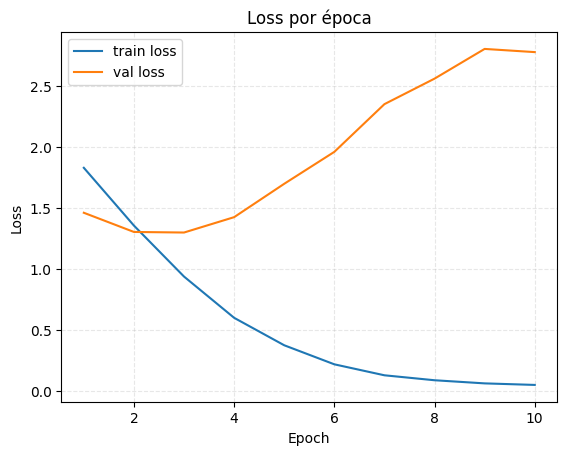

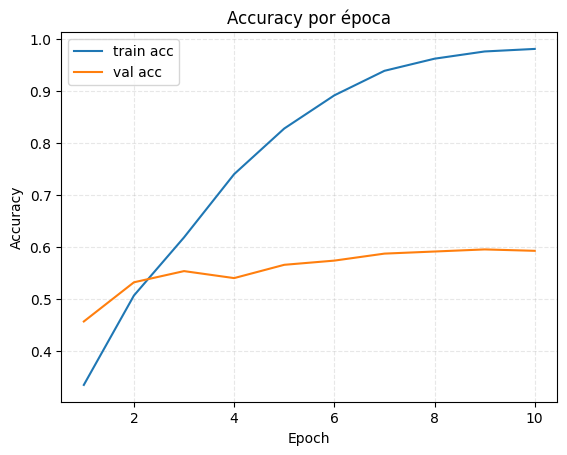

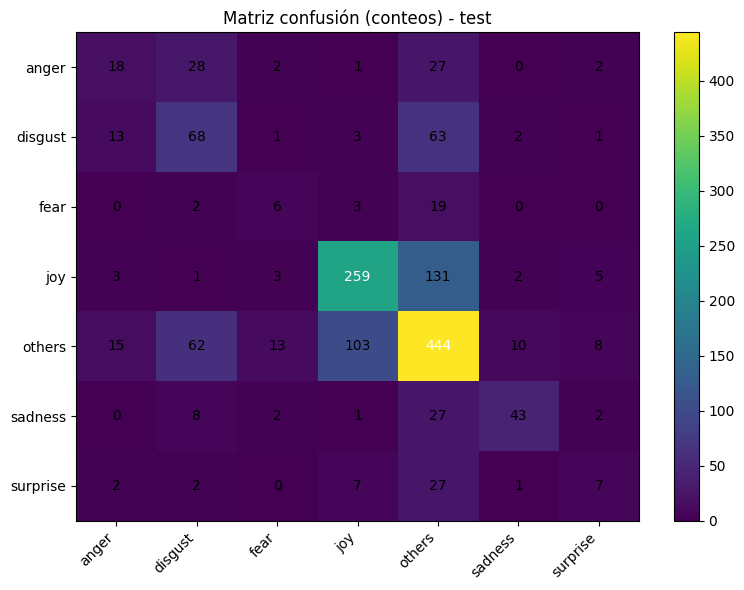

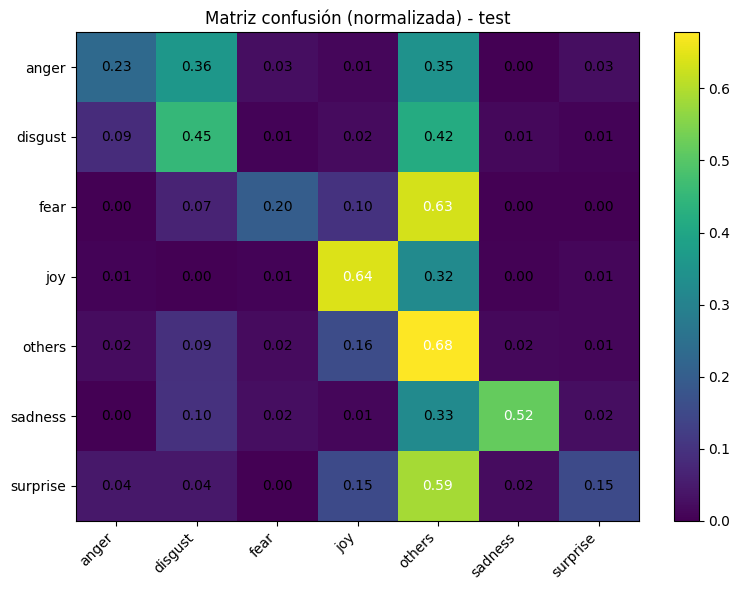

Artefactos guardados en: ./bert_manual_output


In [ ]:
# Gráficos: loss y accuracy, matriz de confusión

# Loss por época
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label="train loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Accuracy
plt.figure()
plt.plot(range(1, len(train_accs)+1), train_accs, label="train acc")
plt.plot(range(1, len(val_accs)+1), val_accs, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Matriz de confusión (conteos y normalizada, para comparar mejor)
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_labels)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (conteos) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (normalizada) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.tight_layout()
plt.show()

# guardar modelo y tokenizer (mejor estado cargado)
model.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
print("Artefactos guardados en:", OUTPUT_DIR)


In [ ]:
# Para entender los ejemplos de abajo, era importante saber qué etiqueta era de qué emoción
display(train_df[['emotion', 'label']].drop_duplicates().sort_values(by='label').reset_index(drop=True))

,emotion,label
0,anger,0
1,disgust,1
2,fear,2
3,joy,3
4,others,4
5,sadness,5
6,surprise,6


In [ ]:
from tabulate import tabulate # para que se vean más entendibles los dataframes

test_results_df = test_df.copy()
test_results_df["true_label"] = test_labels
test_results_df["pred_label"] = test_preds

id2label = {i: l for i, l in enumerate(sorted(train_df["label"].unique()))}
test_results_df["true_label_name"] = test_results_df["true_label"].map(id2label)
test_results_df["pred_label_name"] = test_results_df["pred_label"].map(id2label)

correct_cases = test_results_df[test_results_df["true_label"] == test_results_df["pred_label"]]
wrong_cases   = test_results_df[test_results_df["true_label"] != test_results_df["pred_label"]]

print("\nEjemplos predichos CORRECTAMENTE:")
print(tabulate(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])

print("\nEjemplos predichos INCORRECTAMENTE:")
print(tabulate(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])



Ejemplos predichos CORRECTAMENTE:
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------+
|      | text                                                                                                                                                                              |   true_label_name |   pred_label_name |
|------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------|
|  861 | Best team ever #Barça Best player ever #Messi #BarçaLFC #ChampionsLeague                                                                                                          |                 3 |                 3 |
|  374 | On this #WorldBookDay, search your home 

### PRIMER OUTPUT (NO IMPORTA, IGNORAR)

Este es el modelo tal como está sin transformaciones. No tuvo buenos resultados, por eso le agregué lo de pesos de clases en el segundo output (el de arriba)

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []
train_f1s, val_f1s = [], []

best_val_f1 = -1.0
best_epoch = -1
best_state = None

start_time = time()
for epoch in range(1, EPOCHS+1):
    t0 = time()
    train_loss, train_acc, train_p, train_r, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    elapsed = time() - t0
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} train_f1={train_f1:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}  ({elapsed:.1f}s)")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save(best_state, os.path.join(OUTPUT_DIR, "best_model_state.pt"))

total_time = time() - start_time
print(f"Entrenamiento finalizado en {total_time/60:.2f} minutos. Mejor época: {best_epoch} (val_f1={best_val_f1:.4f})")

if best_state is not None:
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model_state.pt")))
    model.to(device)


Epoch 1/10  train_loss=1.4101 train_acc=0.4797 train_f1=0.4249 | val_loss=1.1505 val_acc=0.5578 val_f1=0.5172  (106.9s)
Epoch 2/10  train_loss=1.0231 train_acc=0.6303 train_f1=0.5975 | val_loss=1.0214 val_acc=0.6062 val_f1=0.5769  (109.7s)
Epoch 3/10  train_loss=0.7573 train_acc=0.7365 train_f1=0.7172 | val_loss=1.1062 val_acc=0.6102 val_f1=0.5927  (111.2s)
Epoch 4/10  train_loss=0.5134 train_acc=0.8349 train_f1=0.8235 | val_loss=1.2273 val_acc=0.6048 val_f1=0.5893  (111.5s)
Epoch 5/10  train_loss=0.3313 train_acc=0.8981 train_f1=0.8951 | val_loss=1.5161 val_acc=0.5914 val_f1=0.5793  (112.4s)
Epoch 6/10  train_loss=0.2114 train_acc=0.9411 train_f1=0.9399 | val_loss=1.8005 val_acc=0.5927 val_f1=0.5805  (112.6s)
Epoch 7/10  train_loss=0.1330 train_acc=0.9662 train_f1=0.9655 | val_loss=2.0155 val_acc=0.5699 val_f1=0.5617  (112.7s)
Epoch 8/10  train_loss=0.0866 train_acc=0.9781 train_f1=0.9779 | val_loss=2.2060 val_acc=0.5941 val_f1=0.5825  (112.7s)
Epoch 9/10  train_loss=0.0656 train_acc=

## MODELO 2: ROBERTA

In [9]:
MODEL_NAME_2 = "roberta-base"

# Tokenizer + Dataset
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME_2)
train_enc = tokenize_texts(train_df["text"].tolist())
val_enc   = tokenize_texts(val_df["text"].tolist())
test_enc  = tokenize_texts(test_df["text"].tolist())

train_ds = EncodedDataset(train_enc, train_df["label"].tolist())
val_ds   = EncodedDataset(val_enc, val_df["label"].tolist())
test_ds  = EncodedDataset(test_enc, test_df["label"].tolist())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
# Modelo (RobertaForSequenceClassification)

model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME_2, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Usando device:", device)

OUTPUT_DIR = "./roberta_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Usando device: cuda


In [11]:
# Optimizador y scheduler

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


In [14]:
# Bucle principal de entrenamiento

train_losses_2, val_losses_2 = [], []
train_accs_2, val_accs_2 = [], []
train_f1s_2, val_f1s_2 = [], []

best_val_f1 = -1.0
best_epoch = -1
best_state = None

start_time = time()
for epoch in range(1, EPOCHS+1):
    t0 = time()
    train_loss, train_acc, train_p, train_r, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, device)

    train_losses_2.append(train_loss)
    val_losses_2.append(val_loss)
    train_accs_2.append(train_acc)
    val_accs_2.append(val_acc)
    train_f1s_2.append(train_f1)
    val_f1s_2.append(val_f1)

    elapsed = time() - t0
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} train_f1={train_f1:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}  ({elapsed:.1f}s)")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save(best_state, os.path.join(OUTPUT_DIR, "best_model_state_2.pt"))

total_time = time() - start_time
print(f"Entrenamiento finalizado en {total_time/60:.2f} minutos. Mejor época: {best_epoch} (val_f1={best_val_f1:.4f})")

if best_state is not None:
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model_state_2.pt")))
    model.to(device)


Epoch 1/10  train_loss=1.7559 train_acc=0.3128 train_f1=0.3408 | val_loss=1.4044 val_acc=0.3871 val_f1=0.3973  (119.8s)
Epoch 2/10  train_loss=1.2740 train_acc=0.5245 train_f1=0.5342 | val_loss=1.1043 val_acc=0.5847 val_f1=0.5819  (121.2s)
Epoch 3/10  train_loss=0.9276 train_acc=0.6084 train_f1=0.6130 | val_loss=1.1336 val_acc=0.5121 val_f1=0.5240  (121.1s)
Epoch 4/10  train_loss=0.6718 train_acc=0.6993 train_f1=0.7002 | val_loss=1.2122 val_acc=0.5672 val_f1=0.5682  (120.9s)
Epoch 5/10  train_loss=0.4749 train_acc=0.7813 train_f1=0.7812 | val_loss=1.4131 val_acc=0.5739 val_f1=0.5832  (120.9s)
Epoch 6/10  train_loss=0.3257 train_acc=0.8310 train_f1=0.8303 | val_loss=1.6382 val_acc=0.5659 val_f1=0.5652  (121.5s)
Epoch 7/10  train_loss=0.2180 train_acc=0.8826 train_f1=0.8821 | val_loss=1.9432 val_acc=0.6169 val_f1=0.6204  (120.9s)
Epoch 8/10  train_loss=0.1733 train_acc=0.9114 train_f1=0.9112 | val_loss=2.1544 val_acc=0.6210 val_f1=0.6199  (121.3s)
Epoch 9/10  train_loss=0.1252 train_acc=

In [15]:
# Evaluación final en test

test_loss, test_acc, test_p, test_r, test_f1, test_preds, test_labels = evaluate(model, test_loader, device)
print("\nResultados en TEST:")
print(f"loss={test_loss:.4f} acc={test_acc:.4f} f1_weighted={test_f1:.4f}")
print("\nReporte por clase (test):\n")
print(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))

with open(os.path.join(OUTPUT_DIR, "classification_report_test.txt"), "w", encoding="utf-8") as f:
    f.write(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))



Resultados en TEST:
loss=2.2191 acc=0.5812 f1_weighted=0.5816

Reporte por clase (test):

              precision    recall  f1-score   support

       anger     0.3818    0.2692    0.3158        78
     disgust     0.4456    0.5695    0.5000       151
        fear     0.2353    0.5333    0.3265        30
         joy     0.6561    0.7178    0.6856       404
      others     0.6496    0.5603    0.6016       655
     sadness     0.6092    0.6386    0.6235        83
    surprise     0.2162    0.1739    0.1928        46

    accuracy                         0.5812      1447
   macro avg     0.4563    0.4947    0.4637      1447
weighted avg     0.5910    0.5812    0.5816      1447



RoBERTa alcanza un desempeño similar al de BERT (≈58% accuracy y F1 ponderado ≈0.58), con ligeras diferencias en cómo maneja las clases:

Hay un mejor desempeño en fear y disgust, aumentando significativamente el recall respecto a BERT. Joy y sadness se mantienen entre las clases más sólidas, con buen balance entre precisión y recall. Others, la clase más numerosa, logra un buen F1 (0.60), aunque con menor recall comparado a BERT. Las clases minoritarias (anger, surprise, fear) siguen siendo difíciles, reflejando el desbalance del dataset. Puede decirse que RoBERTa logra un mejor balance entre recall y precisión en algunas clases poco representadas, pero el rendimiento global es similar al de BERT.

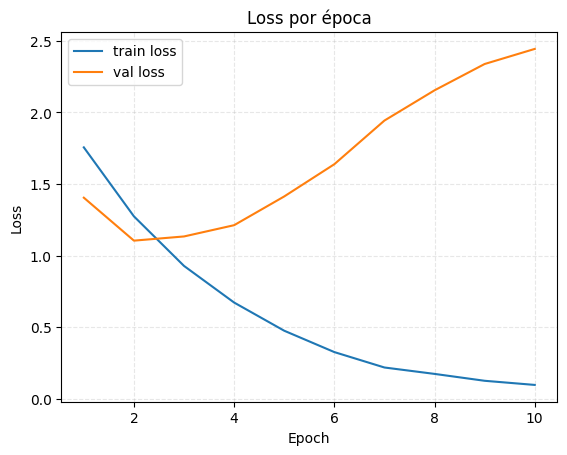

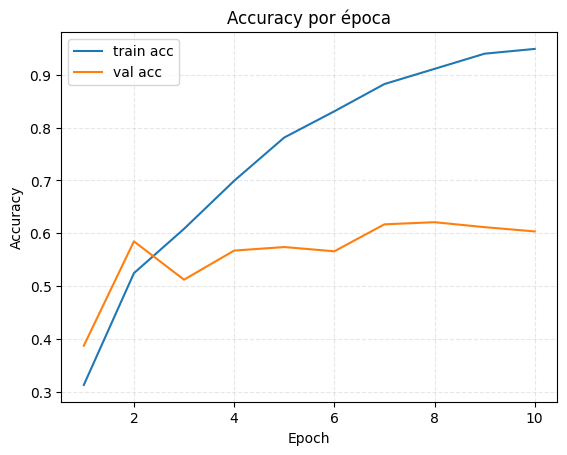

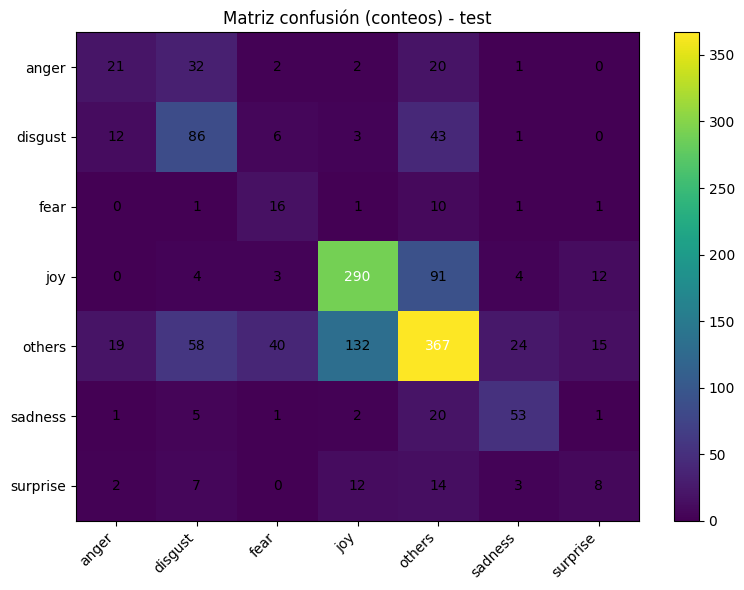

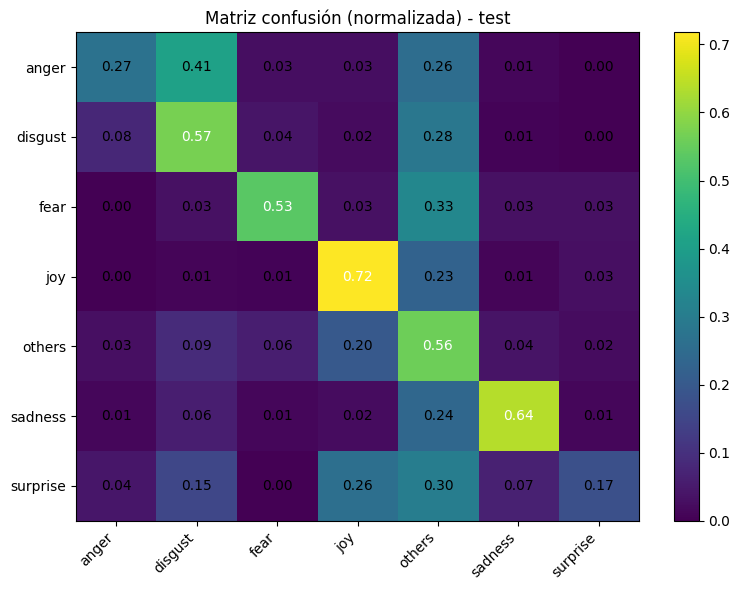

Artefactos guardados en: ./roberta_output


In [17]:
# Gráficos: loss y accuracy, matriz de confusión

# Loss por época
plt.figure()
plt.plot(range(1, len(train_losses_2)+1), train_losses_2, label="train loss")
plt.plot(range(1, len(val_losses_2)+1), val_losses_2, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Accuracy
plt.figure()
plt.plot(range(1, len(train_accs_2)+1), train_accs_2, label="train acc")
plt.plot(range(1, len(val_accs_2)+1), val_accs_2, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Matriz de confusión (conteos y normalizada, para comparar mejor)
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_labels)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (conteos) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (normalizada) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.tight_layout()
plt.show()

# guardar modelo y tokenizer (mejor estado cargado)
model.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
print("Artefactos guardados en:", OUTPUT_DIR)


In [19]:
from tabulate import tabulate # para que se vean más entendibles los dataframes

test_results_df = test_df.copy()
test_results_df["true_label"] = test_labels
test_results_df["pred_label"] = test_preds

id2label = {i: l for i, l in enumerate(sorted(train_df["label"].unique()))}
test_results_df["true_label_name"] = test_results_df["true_label"].map(id2label)
test_results_df["pred_label_name"] = test_results_df["pred_label"].map(id2label)

correct_cases = test_results_df[test_results_df["true_label"] == test_results_df["pred_label"]]
wrong_cases   = test_results_df[test_results_df["true_label"] != test_results_df["pred_label"]]

print("\nEjemplos predichos CORRECTAMENTE:")
print(tabulate(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])

print("\nEjemplos predichos INCORRECTAMENTE:")
print(tabulate(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])



Ejemplos predichos CORRECTAMENTE:
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------+
|      | text                                                                                                                                                                                                                                                                                     |   true_label_name |   pred_label_name |
|------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

## MODELO cardiffnlp/twitter-roberta-base-emotion

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME_3 = "cardiffnlp/twitter-roberta-base-emotion"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_3, use_fast=True)
train_enc = tokenize_texts(train_df["text"].tolist())
val_enc   = tokenize_texts(val_df["text"].tolist())
test_enc  = tokenize_texts(test_df["text"].tolist())

train_ds = EncodedDataset(train_enc, train_df["label"].tolist())
val_ds   = EncodedDataset(val_enc, val_df["label"].tolist())
test_ds  = EncodedDataset(test_enc, test_df["label"].tolist())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
# Modelo (cardiffnlp/twitter-roberta-base-emotion)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_3, num_labels=num_labels,ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Usando device:", device)

OUTPUT_DIR = "./cardiffnlp_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Usando device: cuda


In [13]:
# Optimizador y scheduler

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


In [15]:
# Bucle principal de entrenamiento

train_losses_3, val_losses_3 = [], []
train_accs_3, val_accs_3 = [], []
train_f1s_3, val_f1s_3 = [], []

best_val_f1 = -1.0
best_epoch = -1
best_state = None

start_time = time()
for epoch in range(1, EPOCHS+1):
    t0 = time()
    train_loss, train_acc, train_p, train_r, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, device)

    train_losses_3.append(train_loss)
    val_losses_3.append(val_loss)
    train_accs_3.append(train_acc)
    val_accs_3.append(val_acc)
    train_f1s_3.append(train_f1)
    val_f1s_3.append(val_f1)

    elapsed = time() - t0
    print(f"Epoch {epoch}/{EPOCHS}  train_loss={train_loss:.4f} train_acc={train_acc:.4f} train_f1={train_f1:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f}  ({elapsed:.1f}s)")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save(best_state, os.path.join(OUTPUT_DIR, "best_model_state_3.pt"))

total_time = time() - start_time
print(f"Entrenamiento finalizado en {total_time/60:.2f} minutos. Mejor época: {best_epoch} (val_f1={best_val_f1:.4f})")

if best_state is not None:
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model_state_3.pt")))
    model.to(device)


Epoch 1/10  train_loss=1.5682 train_acc=0.4505 train_f1=0.4580 | val_loss=1.1474 val_acc=0.4624 val_f1=0.4538  (119.2s)
Epoch 2/10  train_loss=1.1304 train_acc=0.5544 train_f1=0.5645 | val_loss=1.0385 val_acc=0.5309 val_f1=0.5233  (117.9s)
Epoch 3/10  train_loss=0.8426 train_acc=0.6465 train_f1=0.6484 | val_loss=1.1188 val_acc=0.5376 val_f1=0.5449  (118.1s)
Epoch 4/10  train_loss=0.5884 train_acc=0.7398 train_f1=0.7403 | val_loss=1.4104 val_acc=0.5927 val_f1=0.5910  (118.3s)
Epoch 5/10  train_loss=0.3987 train_acc=0.8128 train_f1=0.8123 | val_loss=1.5726 val_acc=0.5860 val_f1=0.5873  (118.4s)
Epoch 6/10  train_loss=0.2666 train_acc=0.8687 train_f1=0.8683 | val_loss=1.9127 val_acc=0.6089 val_f1=0.6129  (117.8s)
Epoch 7/10  train_loss=0.1930 train_acc=0.9032 train_f1=0.9029 | val_loss=2.1861 val_acc=0.6277 val_f1=0.6259  (118.3s)
Epoch 8/10  train_loss=0.1336 train_acc=0.9349 train_f1=0.9347 | val_loss=2.3527 val_acc=0.6223 val_f1=0.6213  (118.2s)
Epoch 9/10  train_loss=0.1022 train_acc=

In [16]:
# Evaluación final en test

test_loss, test_acc, test_p, test_r, test_f1, test_preds, test_labels = evaluate(model, test_loader, device)
print("\nResultados en TEST:")
print(f"loss={test_loss:.4f} acc={test_acc:.4f} f1_weighted={test_f1:.4f}")
print("\nReporte por clase (test):\n")
print(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))

with open(os.path.join(OUTPUT_DIR, "classification_report_test.txt"), "w", encoding="utf-8") as f:
    f.write(classification_report(test_labels, test_preds, target_names=le.classes_, digits=4, zero_division=0))



Resultados en TEST:
loss=2.4319 acc=0.5964 f1_weighted=0.5893

Reporte por clase (test):

              precision    recall  f1-score   support

       anger     0.4333    0.1667    0.2407        78
     disgust     0.3932    0.5364    0.4538       151
        fear     0.4000    0.3333    0.3636        30
         joy     0.6697    0.7327    0.6998       404
      others     0.6421    0.6244    0.6331       655
     sadness     0.6234    0.5783    0.6000        83
    surprise     0.2000    0.1304    0.1579        46

    accuracy                         0.5964      1447
   macro avg     0.4802    0.4432    0.4498      1447
weighted avg     0.5924    0.5964    0.5893      1447



CardiffNLP presenta el mejor rendimiento global entre los tres modelos probados, alcanzando 59.6% de accuracy y un F1 ponderado de 0.5893.

Se observa una mejora notable en la clase fear (F1=0.36) y un mayor recall en disgust, aunque sigue sacrificando precisión. La clase joy mantiene el desempeño más alto (F1≈0.70). Others logra un balance estable con F1=0.63, siendo consistente con su mayor representación. Anger y surprise siguen siendo las categorías más débiles, con baja cobertura en recall (<0.20).

En síntesis, CardiffNLP logra una mejora ligera pero consistente frente a BERT y RoBERTa en términos de accuracy y F1 ponderado, mostrando ventajas sobre todo en clases minoritarias.

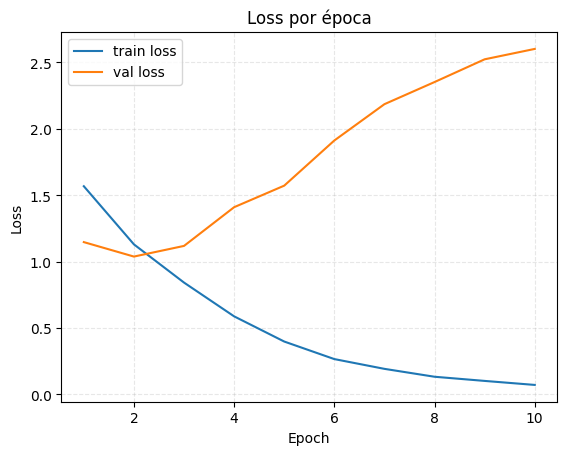

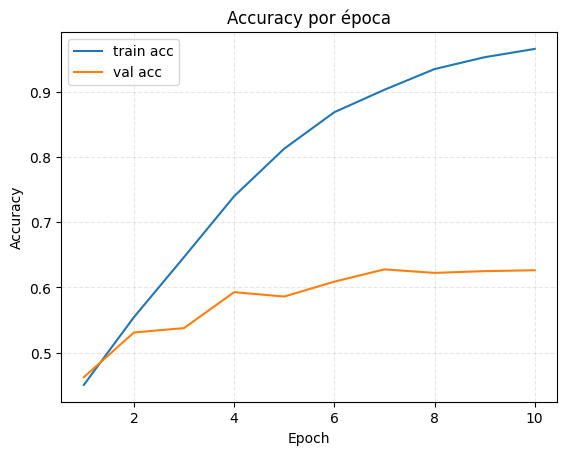

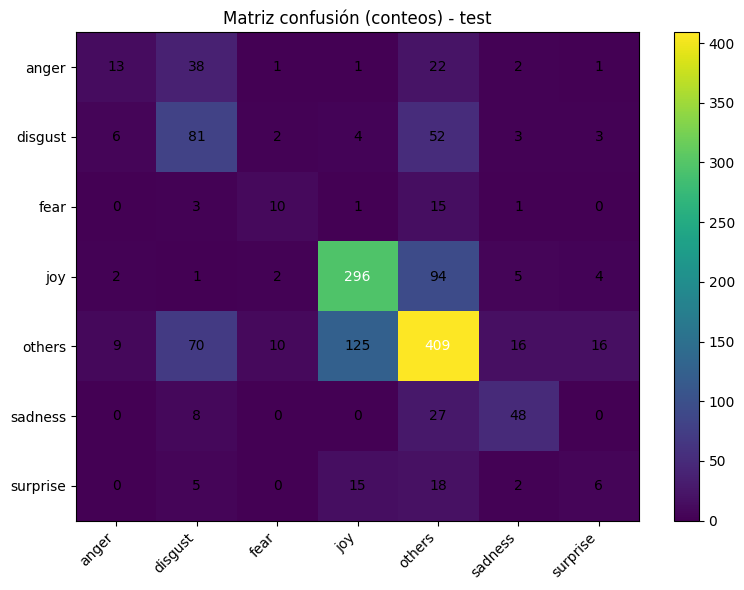

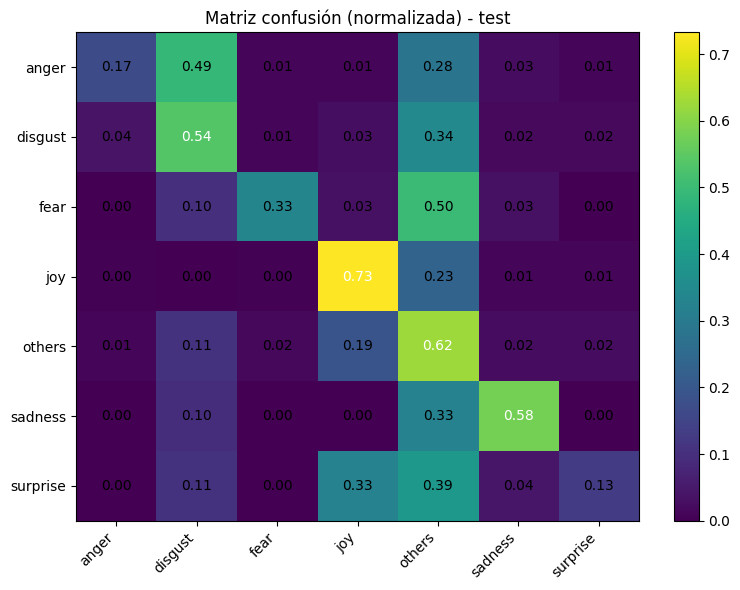

Artefactos guardados en: ./cardiffnlp_output


In [18]:
# Gráficos: loss y accuracy, matriz de confusión

# Loss por época
plt.figure()
plt.plot(range(1, len(train_losses_3)+1), train_losses_3, label="train loss")
plt.plot(range(1, len(val_losses_3)+1), val_losses_3, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Accuracy
plt.figure()
plt.plot(range(1, len(train_accs_3)+1), train_accs_3, label="train acc")
plt.plot(range(1, len(val_accs_3)+1), val_accs_3, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy por época")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

# Matriz de confusión (conteos y normalizada, para comparar mejor)
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_labels)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (conteos) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title("Matriz confusión (normalizada) - test")
plt.colorbar()
plt.xticks(range(num_labels), le.classes_, rotation=45, ha="right")
plt.yticks(range(num_labels), le.classes_)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i,j]:.2f}", ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.tight_layout()
plt.show()

# guardar modelo y tokenizer (mejor estado cargado)
model.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "best_model"))
print("Artefactos guardados en:", OUTPUT_DIR)


In [19]:
from tabulate import tabulate # para que se vean más entendibles los dataframes

test_results_df = test_df.copy()
test_results_df["true_label"] = test_labels
test_results_df["pred_label"] = test_preds

id2label = {i: l for i, l in enumerate(sorted(train_df["label"].unique()))}
test_results_df["true_label_name"] = test_results_df["true_label"].map(id2label)
test_results_df["pred_label_name"] = test_results_df["pred_label"].map(id2label)

correct_cases = test_results_df[test_results_df["true_label"] == test_results_df["pred_label"]]
wrong_cases   = test_results_df[test_results_df["true_label"] != test_results_df["pred_label"]]

print("\nEjemplos predichos CORRECTAMENTE:")
print(tabulate(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(correct_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])

print("\nEjemplos predichos INCORRECTAMENTE:")
print(tabulate(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]], headers="keys", tablefmt="psql"))
# print(wrong_cases.sample(3, random_state=42)[["text", "true_label_name", "pred_label_name"]])



Ejemplos predichos CORRECTAMENTE:
+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------+
|      | text                                                                                                                                                                                                                                                                        |   true_label_name |   pred_label_name |
|------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------------|
| 1198 |

##